<a href="https://colab.research.google.com/github/dipta007/Movie-Recommendation/blob/master/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the Google Drive

In [1]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab_data/MR1'       # path to your project on Drive
drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/My Drive/Colab_data/MR1’: File exists
/content/drive/My Drive/Colab_data/MR1
data/  final-1  model  model-multi-label  multilayer_perceptron_graph.png


# Get the ratings

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

DATA_PATH = './data/ml-latest-small'

ratings = pd.read_csv(f"{DATA_PATH}/ratings.csv")
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

# Get all the movies and their mapping

In [3]:
movies = pd.read_csv(f"{DATA_PATH}/movies.csv")
movies_ind_to_name = dict(zip(movies.movieId, movies.title))
movies_name_to_ind = dict(zip(movies.title, movies.movieId))
movies_ind_to_genre = dict(zip(movies.movieId, movies.genres))
movies.head()

movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]

# Get all the TMDB Links

In [0]:
# links = pd.read_csv(f"{DATA_PATH}/links.csv")
# links['tmdbId'] = links['tmdbId'].fillna(-1).astype(int)
# movie_to_tmdb = dict(zip(links.movieId, links.tmdbId))

# Get MetaData

In [0]:
# from ast import literal_eval

# metadata = pd.read_csv(f"{DATA_PATH}/movies_metadata.csv")
# metadata.head()

# features = ['overview', ]

# Get all the Genres

In [0]:
maxLen = max(movies['genres'].apply(lambda x: len(x.split('|'))))

def make_all_same(x):
  now = x.split("|")
  while len(now) < maxLen:
    now.append("")
  return now

movies['genres_list'] = movies['genres'].apply(make_all_same)

In [7]:
s = set()
for v in movies['genres_list'].values:
  for g in v:
    s.add(g)

n_genres = len(s)
n_genres

21

In [0]:
# ratings['tmdbId'] = ratings['movieId'].apply(lambda x: movie_to_tmdb[x])
# ratings = ratings.drop(['timestamp'], axis=1)
# ratings.head()

In [9]:
ratings = pd.merge(ratings, movies, "inner", "movieId")
ratings.head()

userId  ...                                        genres_list
0       1  ...  [Adventure, Animation, Children, Comedy, Fanta...
1       5  ...  [Adventure, Animation, Children, Comedy, Fanta...
2       7  ...  [Adventure, Animation, Children, Comedy, Fanta...
3      15  ...  [Adventure, Animation, Children, Comedy, Fanta...
4      17  ...  [Adventure, Animation, Children, Comedy, Fanta...

[5 rows x 7 columns]

In [10]:
ratings = ratings.drop(['title', 'genres'], axis=1)
ratings.head()

userId  ...                                        genres_list
0       1  ...  [Adventure, Animation, Children, Comedy, Fanta...
1       5  ...  [Adventure, Animation, Children, Comedy, Fanta...
2       7  ...  [Adventure, Animation, Children, Comedy, Fanta...
3      15  ...  [Adventure, Animation, Children, Comedy, Fanta...
4      17  ...  [Adventure, Animation, Children, Comedy, Fanta...

[5 rows x 5 columns]

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode the userId
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

# Encode the movie ids
movie_enc = LabelEncoder()
movie_enc.fit(movies['movieId'])
ratings['movie'] = movie_enc.transform(ratings['movieId'].values)
n_movies = movies['movieId'].nunique()

# encode genere list
genre_enc = LabelEncoder()
genre_enc.fit(list(s))
ratings['genres_list'] = ratings['genres_list'].apply(lambda x: genre_enc.transform(x))
ratings.head()

# get ratings info
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

ratings.head()

userId  movieId  rating  ...                      genres_list user  movie
0       1        1     4.0  ...  [3, 4, 5, 6, 10, 0, 0, 0, 0, 0]    0      0
1       5        1     4.0  ...  [3, 4, 5, 6, 10, 0, 0, 0, 0, 0]    4      0
2       7        1     4.5  ...  [3, 4, 5, 6, 10, 0, 0, 0, 0, 0]    6      0
3      15        1     2.5  ...  [3, 4, 5, 6, 10, 0, 0, 0, 0, 0]   14      0
4      17        1     4.5  ...  [3, 4, 5, 6, 10, 0, 0, 0, 0, 0]   16      0

[5 rows x 7 columns]

In [12]:
n_users, n_movies, n_genres

(610, 9742, 21)

In [13]:
X1 = ratings[['user', 'movie']].values
X2 = np.array([list(val) for val in ratings['genres_list'].values])
X = np.concatenate((X1, X2), axis=1)
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=74)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 12), (10084, 12), (90752,), (10084,))

In [0]:
X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2:]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2:]]

In [15]:
del X_train
del X_test
import gc
gc.collect()

0

In [16]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout, Activation, Lambda, LSTM, Flatten
from keras.layers import Concatenate, Dense, Dropout

def Model1(min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, 50)(user)
    u = Flatten()(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, 50, name="movies")(movie)
    m = Flatten()(m)

    genre = Input(shape=(10,))
    g = Embedding(n_genres, 10)(genre)
    g = Flatten()(g)
    
    x = Concatenate()([u, m, g])
    x = Dropout(0.05)(x)
    
    x = Dense(128, kernel_initializer='he_normal', activation="relu")(x)

    x = Dense(10, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal', activation="sigmoid")(x)

    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie, genre], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    return model

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
____________________________________________________________________________________________

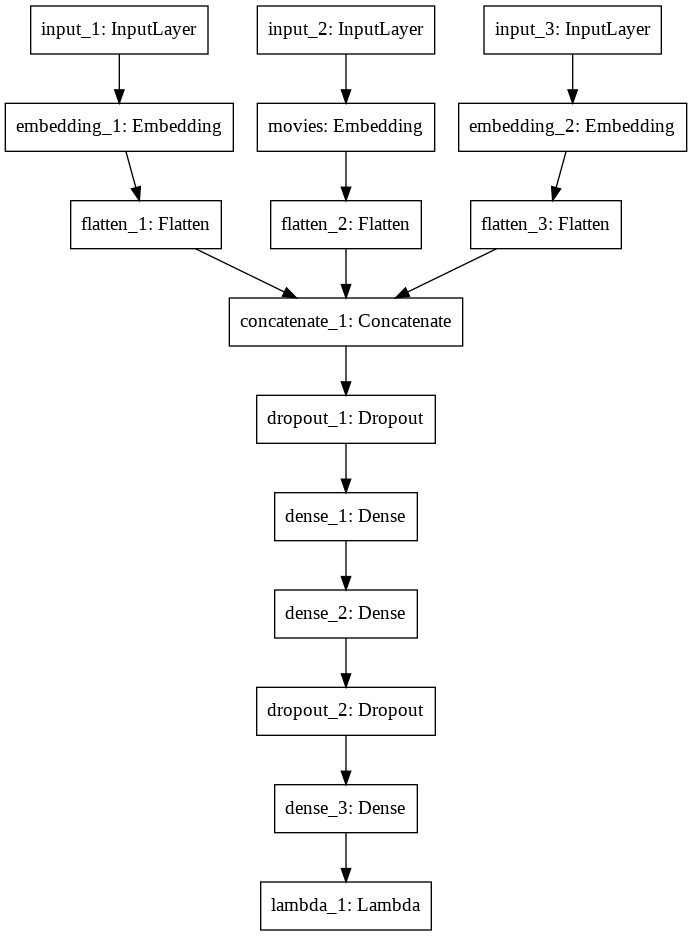

In [17]:
model = Model1(min_rating, max_rating)
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

CHECKPOINT_PATH = './final-1'

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', patience=4))
callbacks.append(ModelCheckpoint(CHECKPOINT_PATH,  monitor='val_loss', save_best_only=True, save_weights_only=True))

In [0]:
# np.array(X_train_array).shape
# np.array(X_train_array[2]).shape
# X_train_array[2]
# X_train_array[2]

In [20]:
history = model.fit(x=X_train_array, y=y_train, batch_size=128, epochs=50,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/50
90752/90752 [==============================] - 4s 46us/step - loss: 0.9015 - accuracy: 0.2824 - val_loss: 0.7564 - val_accuracy: 0.3200
Epoch 2/50
90752/90752 [==============================] - 4s 43us/step - loss: 0.7587 - accuracy: 0.3151 - val_loss: 0.7386 - val_accuracy: 0.3261
Epoch 3/50
90752/90752 [==============================] - 4s 43us/step - loss: 0.7079 - accuracy: 0.3279 - val_loss: 0.7345 - val_accuracy: 0.3299
Epoch 4/50
90752/90752 [==============================] - 4s 43us/step - loss: 0.6735 - accuracy: 0.3402 - val_loss: 0.7403 - val_accuracy: 0.3276
Epoch 5/50
90752/90752 [==============================] - 4s 43us/step - loss: 0.6377 - accuracy: 0.3491 - val_loss: 0.7431 - val_accuracy: 0.3291
Epoch 6/50
90752/90752 [==============================] - 4s 43us/step - loss: 0.6003 - accuracy: 0.3584 - val_loss: 0.7522 - val_accuracy: 0.3269
Epoch 7/50
90752/90752 [==============================] - 4s 43us/st

In [0]:
model.load_weights(CHECKPOINT_PATH)

In [22]:
model.evaluate(X_test_array, y_test)

10084/10084 [==============================] - 0s 20us/step


[0.734513720317948, 0.32992860674858093]